In [35]:
# imports
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import math

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [37]:
input_size = 552
hidden_size = 100
num_classes = 4
testing_size = 0.2
validation_size = 0.2
num_epochs = 10
batch_size = 128
learning_rate = 0.001

In [38]:
transform = transforms.Compose([
     transforms.ToTensor(),
 ])

In [39]:
#data_path = "/home/ivan/Documentos/ivan/small.csv" 
#df = pd.read_csv(data_path)

In [40]:
class CustomDataset(Dataset):

    def __init__(self):
        # data loading
        #data_path = "/home/ivang/tests/data.csv"
        data_path = "/home/ivan/Documentos/ivan/small.csv" 
        xy = pd.read_csv(data_path)
        print(len(xy))
        self.x = torch.tensor(xy.iloc[:, 0:552].to_numpy()) # tensor with the 553 values --> 184 for x, 184 for dx and 184 for d2x
        self.y = torch.tensor(xy.iloc[:, 552].to_numpy())  # tensor with the labels
        self.n_samples = xy.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

df = CustomDataset()
first_data = df[0]
features, labels = first_data
print(features, labels)


50000
tensor([ 9.7357e-02,  9.9201e-02,  1.0027e-01,  1.0236e-01,  1.0440e-01,
         1.0743e-01,  1.1104e-01,  1.1504e-01,  1.1920e-01,  1.2255e-01,
         1.2601e-01,  1.2952e-01,  1.3324e-01,  1.3683e-01,  1.4005e-01,
         1.4317e-01,  1.4615e-01,  1.4854e-01,  1.5041e-01,  1.5183e-01,
         1.5260e-01,  1.5302e-01,  1.5280e-01,  1.5177e-01,  1.5057e-01,
         1.4887e-01,  1.4672e-01,  1.4419e-01,  1.4119e-01,  1.3700e-01,
         1.3173e-01,  1.2431e-01,  1.1527e-01,  1.0450e-01,  9.1388e-02,
         7.6653e-02,  6.1122e-02,  4.7322e-02,  3.7857e-02,  3.5286e-02,
         3.6215e-02,  3.7966e-02,  4.0553e-02,  4.3224e-02,  4.5438e-02,
         4.5263e-02,  4.3532e-02,  4.0932e-02,  3.8386e-02,  3.5536e-02,
         3.2763e-02,  2.9693e-02,  2.6567e-02,  2.3936e-02,  2.4607e-02,
         2.8102e-02,  3.3582e-02,  3.8637e-02,  4.1589e-02,  4.3225e-02,
         4.4860e-02,  4.5679e-02,  4.6660e-02,  4.8060e-02,  4.9498e-02,
         5.1441e-02,  5.2451e-02,  5.3703e-02

In [41]:
train_df, test_df = train_test_split(df, test_size=testing_size, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=validation_size, random_state=42)

In [42]:
# Data loaders for training and validation sets
train_loader = torch.utils.data.DataLoader(dataset=train_df, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_df, batch_size=batch_size, shuffle=False)

# The test_loader remains unchanged for the test set
test_loader = torch.utils.data.DataLoader(dataset=test_df, batch_size=batch_size, shuffle=False)

In [43]:
class FCNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size).double()
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes).double()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = FCNet(input_size, hidden_size, num_classes).to(device)

In [44]:
# Hyper-parameters
learning_rate = 0.001
# optimizer
criterion = nn.CrossEntropyLoss()
#Loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [45]:
def Train(model,train_loader,optimizer):
    correct = 0
    total = 0
    for i, (values, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        values = values.to(device)
        labels = labels.double().to(device)

        # Forward pass
        outputs = model(values)
        loss = criterion(outputs, labels.long())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    accuracy = (100 * correct / total)

    return loss.item(), accuracy

In [46]:
def Validate(model,val_loader):
  with torch.no_grad():
      correct = 0
      total = 0
      for values, labels in val_loader:
          values = values.to(device)
          labels = labels.double().to(device)

          # Forward pass
          outputs = model(values)
          loss = criterion(outputs, labels.long())
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      accuracy = (100 * correct / total)
  return loss.item(),accuracy

In [47]:
# Hyper-parameters
num_epochs = 100
T_loss= []
v_loss =[]
T_acc = []
v_acc = []

# run
for epoch in range(num_epochs):

  train_loss, train_acc = Train(model, train_loader, optimizer)
  val_loss, val_acc = Validate(model, val_loader)

  print ('Epoch [{}/{}], train Loss: {:.4f}, train acc: {:.4f}, val Loss: {:.4f} , val acc: {:.4f}'
            .format(epoch+1, num_epochs, train_loss,train_acc, val_loss,val_acc))
  T_loss.append(train_loss)
  v_loss.append(val_loss)
  T_acc.append(train_acc)
  v_acc.append(val_acc)

Epoch [1/100], train Loss: 1.0352, train acc: 71.9250, val Loss: 1.0288 , val acc: 73.9375
Epoch [2/100], train Loss: 0.8843, train acc: 73.7750, val Loss: 0.8003 , val acc: 75.4625
Epoch [3/100], train Loss: 0.5949, train acc: 79.8937, val Loss: 0.6344 , val acc: 84.4250
Epoch [4/100], train Loss: 0.4878, train acc: 86.1688, val Loss: 0.5211 , val acc: 88.4125
Epoch [5/100], train Loss: 0.4345, train acc: 88.3250, val Loss: 0.4437 , val acc: 89.2750
Epoch [6/100], train Loss: 0.3540, train acc: 88.9469, val Loss: 0.3879 , val acc: 89.5000
Epoch [7/100], train Loss: 0.3551, train acc: 89.1719, val Loss: 0.3463 , val acc: 89.7125
Epoch [8/100], train Loss: 0.2771, train acc: 89.6125, val Loss: 0.3140 , val acc: 90.5250
Epoch [9/100], train Loss: 0.2641, train acc: 90.6250, val Loss: 0.2885 , val acc: 91.4000
Epoch [10/100], train Loss: 0.2797, train acc: 91.4969, val Loss: 0.2679 , val acc: 92.2625
Epoch [11/100], train Loss: 0.2150, train acc: 92.1594, val Loss: 0.2511 , val acc: 92.83

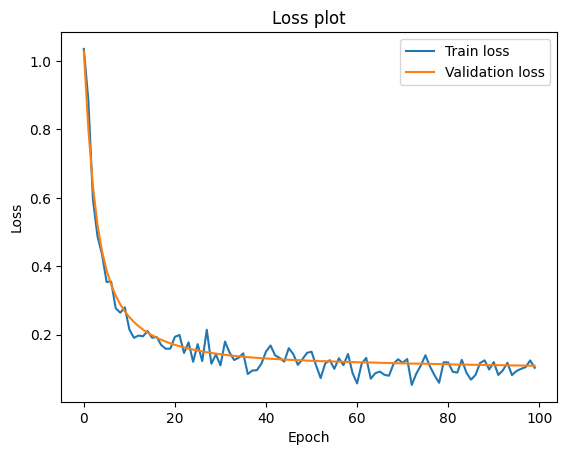

In [48]:
epochs = [i for i in range (num_epochs)]

plt.plot(epochs, T_loss, label='Train loss')
plt.plot(epochs, v_loss, label='Validation loss')

# Add labels and a title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

# Add a legend to distinguish lines
plt.legend()

# Display the plot
plt.show()


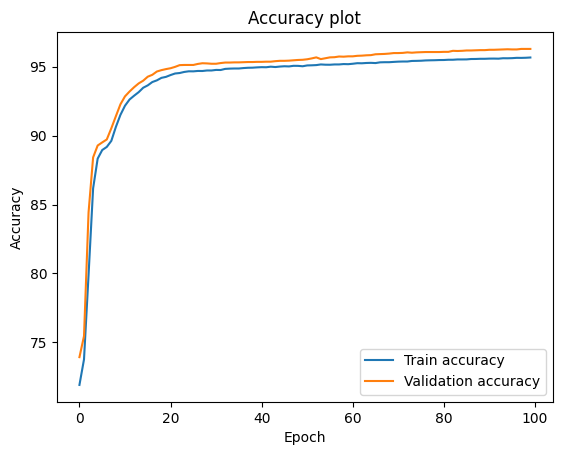

In [49]:
plt.plot(epochs, T_acc, label='Train accuracy')
plt.plot(epochs, v_acc, label='Validation accuracy')

# Add labels and a title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

# Add a legend to distinguish lines
plt.legend()

# Display the plot
plt.show()

In [50]:
predict = []
with torch.no_grad():
    correct = 0
    total = 0
    for values, labels in test_loader:
        values = values.to(device)
        labels = labels.to(device)
        outputs = model(values)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predict.extend(predicted.tolist())



    print('Accuracy of the network: {} %'.format(100 * correct / total))
    print(len(predict))

Accuracy of the network: 95.69 %
10000


Confusion matrix, without normalization
[[3145    0    0    0]
 [   0 1460  169    0]
 [   0  207  776    0]
 [   0    0   55 4188]]


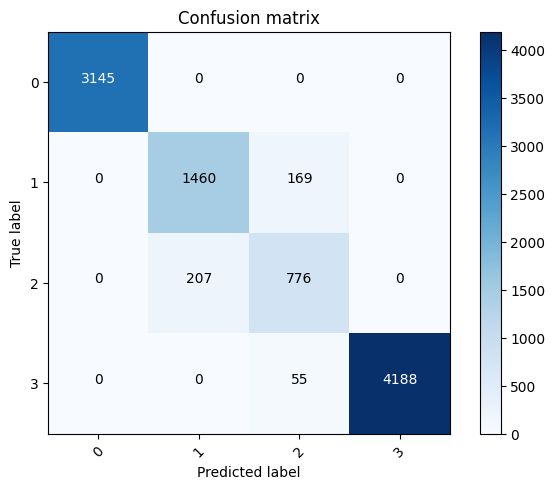

In [51]:
#confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

x_test = []
y_test = []
for data, target in test_loader:
  x_test.extend(data)
  y_test.extend(target)

cm = confusion_matrix(y_test, predict)
plot_confusion_matrix(cm,list(range(4)))

In [52]:
#torch.save(model.state_dict(), 'test_model_ivan.ckpt')